In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel,roberts, scharr, prewitt
from sklearn.model_selection import train_test_split

In [3]:
for directory_path in glob.glob("/content/drive/MyDrive/data3a/training/*"):
    label = directory_path.split("-")[-1]
    print(label)


minor
moderate
severe


In [4]:

#Resize images to
SIZE = 128

#Capturing images and labels into arrays.
train_images = []
train_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/data3a/training/*"):
    label = directory_path.split("-")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.JPEG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

        img = cv2.resize(img, (SIZE, SIZE)) #Resizing images
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        train_images.append(img)
        train_labels.append(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

        img = cv2.resize(img, (SIZE, SIZE)) 
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        train_images.append(img)
        train_labels.append(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
 
        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional step. Change BGR to RGB
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

minor
moderate
severe


In [5]:
train_images.shape,train_labels.shape

((1383, 128, 128), (1383,))

In [6]:
#Test images
test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/drive/MyDrive/data3a/validation/*"):
    fruit_label = directory_path.split("-")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.JPEG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional
        test_images.append(img)
        test_labels.append(fruit_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional
        test_images.append(img)
        test_labels.append(fruit_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  

        img = cv2.resize(img, (SIZE, SIZE))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Optional
        test_images.append(img)
        test_labels.append(fruit_label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
test_images.shape,test_labels.shape

((248, 128, 128), (248,))

In [8]:
#Encoding labels from text (folder names) to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [9]:
#Spliting data into train, validation and test datasets 

x_train, x_val,y_train, y_val = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=1)
x_test, y_test = test_images, test_labels_encoded


In [10]:
# Normalizing pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [11]:
x_train.shape , y_train.shape , x_val.shape , y_val.shape , x_test.shape , y_test.shape

((1106, 128, 128), (1106,), (277, 128, 128), (277,), (248, 128, 128), (248,))

In [12]:
# FEATURE EXTRACTOR function
# input shape is (n, x, y, c) - number of images, x, y, and channels
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):  #Iterating through each file 
        
        df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
        
        input_img = x_train[image, :,:]
        img = input_img

         # FEATURE 1 - Pixel values         
        #Adding pixel values to the data frame
        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values  
        
        # FEATURE 2 - Bunch of Gabor filter responses
                #Generating Gabor features
        num = 1 
        kernels = []
        for theta in range(2):   #Defining number of thetas
            theta = theta / 4. * np.pi
            for sigma in (1, 3):  #Sigma with 1 and 3
                lamda = np.pi/4
                gamma = 0.5
                
                gabor_label = 'Gabor' + str(num)  #Labelling Gabor columns as Gabor1, Gabor2, etc.
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)

                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img  #Labeling columns as Gabor1, Gabor2, etc.
                num += 1  #Iterate all over
                
         
        # FEATURE 3 Sobel
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1
       
        #Adding filters as needed
        #ROBERTS EDGE
        edge_roberts = roberts(img)
        edge_roberts1 = edge_roberts.reshape(-1)
        df['Roberts'] = edge_roberts1
        #SCHARR
        edge_scharr = scharr(img)
        edge_scharr1 = edge_scharr.reshape(-1)
        df['Scharr'] = edge_scharr1

        #PREWITT
        edge_prewitt = prewitt(img)
        edge_prewitt1 = edge_prewitt.reshape(-1)
        df['Prewitt'] = edge_prewitt1

        #GAUSSIAN with sigma=3
        from scipy import ndimage as nd
        gaussian_img = nd.gaussian_filter(img, sigma=3)
        gaussian_img1 = gaussian_img.reshape(-1)
        df['Gaussian s3'] = gaussian_img1

        #GAUSSIAN with sigma=7
        gaussian_img2 = nd.gaussian_filter(img, sigma=7)
        gaussian_img3 = gaussian_img2.reshape(-1)
        df['Gaussian s7'] = gaussian_img3

        #MEDIAN with sigma=3
        median_img = nd.median_filter(img, size=3)
        median_img1 = median_img.reshape(-1)
        df['Median s3'] = median_img1

        #VARIANCE with size=3
        variance_img = nd.generic_filter(img, np.var, size=3)
        variance_img1 = variance_img.reshape(-1)
        df['Variance s3'] = variance_img1  #Add column to original dataframe
        
        #Append features from current image to the dataset
        # image_dataset = image_dataset.append(df)
        image_dataset= pd.concat([image_dataset, df], axis=0)
        
    return image_dataset

In [13]:
#Extracting features from training images
image_features = feature_extractor(x_train)

In [14]:
image_features.shape

(18120704, 13)

In [15]:
#Reshaping to a vector for ML training
n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (x_train.shape[0], -1))  #Reshape to #images, features
X_for_RF.shape

(1106, 212992)

In [22]:
#Define the classifier
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Fit the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding


RandomForestClassifier(n_estimators=50, random_state=42)

In [17]:
#Predict on Test data
#Extract features from test data and reshape, just like training data
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

In [18]:
X_for_RF.shape,y_train.shape

((1106, 212992), (1106,))

In [19]:
#Predict on test
test_prediction_RF = RF_model.predict(test_for_RF)
#Inverse le transform to get original label back. 
test_prediction_RF = le.inverse_transform(test_prediction_RF)

In [20]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_prediction_RF))

Accuracy =  0.5403225806451613


<Axes: >

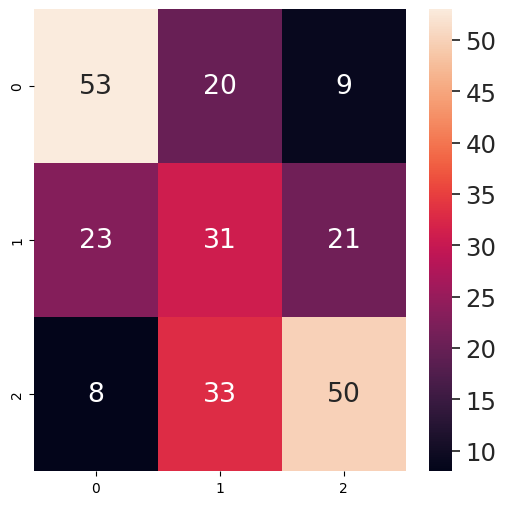

In [21]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_prediction_RF)

fig, ax = plt.subplots(figsize=(6,6))         
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)